## Linear fit with x error, y error, and instrinsic scatter

In the following form
$$
y = (a\pm\Delta a) + (b\pm\Delta b)x \pm (\sigma\pm\Delta\sigma)
$$

### Maximum likelihood

With `scipy.optimize` and bootstrap

In [1]:
import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def neg_log_gaussian_likelihood(p, x, y, dx, dy):
    '''
    negative log of Gaussuan likelihood
    '''
    a = p[0]
    b = p[1]
    sig = p[2]
    sigi2 = sig**2 + dy**2 + (b*dx)**2
    return np.sum(np.log(sigi2) + (y-a-b*x)**2/sigi2)

def linear_fit_maxlike(x, y, dx, dy):
    bnds = ((None, None), (None, None), (0, None))
    o = minimize(neg_log_gaussian_likelihood, [1.,0.,1.], args=(x,y,dx,dy), bounds=bnds)
    return o.x

def linear_fit_maxlike_boot(x, y, dx, dy, size=100):
    data = np.column_stack((x, y, dx, dy))
    data_boot = data[np.random.randint(0, len(x), (size, len(x)))]
    
    a_list = np.zeros(size)
    b_list = np.zeros(size)
    sig_list = np.zeros(size)
    
    for i, d in enumerate(data_boot):
        bnds = ((None, None), (None, None), (0, None))
        o = minimize(neg_log_gaussian_likelihood, [1.,0.,1.], 
            args=(d[:,0],d[:,1],d[:,2],d[:,3]), bounds=bnds)
        a_list[i] = o.x[0]
        b_list[i] = o.x[1]
        sig_list[i] = o.x[2]
        
    return a_list, b_list, sig_list

In [2]:
# generate test data

np.random.seed(10)

a_true = 0
b_true = 1
sig_true = 5

N_samp = 100
x = 5*np.random.normal(size=N_samp)
y = a_true + b_true*x
dx = 0 + 2*np.random.rand(N_samp)
dy = 0 + 2*np.random.rand(N_samp)
x = x + dx*np.random.normal(size=N_samp) # add scatter
y = y + dy*np.random.normal(size=N_samp) + sig_true*np.random.normal(size=N_samp)

In [3]:
a, b, sig = linear_fit_maxlike_boot(x, y, dx, dy, 10000)
print('a_true = %.3f, a = %.3f +- %.3f'%(a_true, np.mean(a), np.std(a)))
print('b_true = %.3f, b = %.3f +- %.3f'%(b_true, np.mean(b), np.std(b)))
print('sig_true = %.3f, sig = %.3f +- %.3f'%(sig_true, np.mean(sig), np.std(sig)))

a_true = 0.000, a = -0.433 +- 0.421
b_true = 1.000, b = 1.068 +- 0.088
sig_true = 5.000, sig = 3.875 +- 0.295


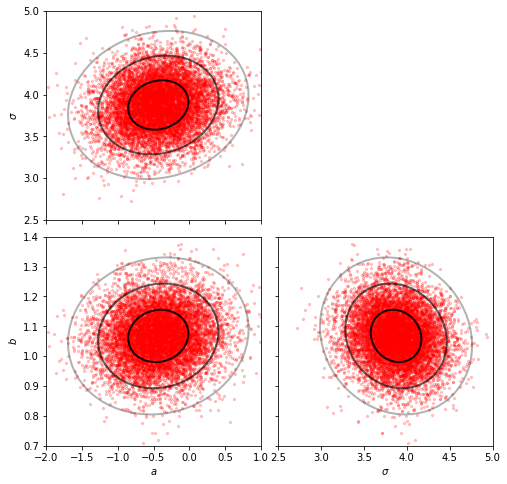

In [4]:
# visualization

def confidence_ellipse(ax, x, y, n_std=3.0, facecolor='none', **kwargs):
    
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

fig = plt.figure(figsize=(8,8))
ax0 = plt.subplot2grid((2, 2), (1, 0))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (1, 1))
fig.subplots_adjust(hspace=0.08, wspace=0.08)

ax0.scatter(a, b, c='r', s=5, alpha=0.2)
confidence_ellipse(ax0, a, b, 1, ec='k', lw=2, alpha=0.9)
confidence_ellipse(ax0, a, b, 2, ec='k', lw=2, alpha=0.6)
confidence_ellipse(ax0, a, b, 3, ec='k', lw=2, alpha=0.3)
ax1.scatter(a, sig, c='r', s=5, alpha=0.2)
confidence_ellipse(ax1, a, sig, 1, ec='k', lw=2, alpha=0.9)
confidence_ellipse(ax1, a, sig, 2, ec='k', lw=2, alpha=0.6)
confidence_ellipse(ax1, a, sig, 3, ec='k', lw=2, alpha=0.3)
ax2.scatter(sig, b, c='r', s=5, alpha=0.2)
confidence_ellipse(ax2, sig, b, 1, ec='k', lw=2, alpha=0.9)
confidence_ellipse(ax2, sig, b, 2, ec='k', lw=2, alpha=0.6)
confidence_ellipse(ax2, sig, b, 3, ec='k', lw=2, alpha=0.3)

# plot parameters
ax0.set_xlabel(r'$a$')
ax2.set_xlabel(r'$\sigma$')
ax0.set_ylabel(r'$b$')
ax1.set_ylabel(r'$\sigma$')
ax0.set_xlim(-2, 1)
ax1.set_xlim(-2, 1)
ax1.set_xticklabels([])
ax0.set_ylim(0.7, 1.4)
ax2.set_ylim(0.7, 1.4)
ax2.set_yticklabels([])
ax2.set_xlim(2.5, 5)
ax1.set_ylim(2.5, 5)

plt.show()

In [7]:
def plot_linear_fit_with_error(ax, xmin, xmax, xmean, ymean, a, da, b, db, sig, dsig, **kwargs):
    
    x = np.linspace(xmin, xmax, 100+1)
    y = a+b*(x-xmean)+ymean
    dy = np.sqrt(sig**2 + da**2 + (db*(x-xmean))**2)
    return ax.fill_between(x, y-dy, y+dy, **kwargs)
    
#     if (xmin < xmean) & (xmean < xmax):
#         ax.fill_between([xmin,xmean], 
#             [(a+b*(xmin-xmean)-da-db*(xmean-xmin)-sig-dsig+ymean), (a-da-sig-dsig+ymean)], 
#             [(a+b*(xmin-xmean)+da+db*(xmean-xmin)+sig+dsig+ymean), (a+da+sig+dsig+ymean)], 
#             **kwargs)
#         return ax.fill_between([xmean,xmax],
#             [(a-da-sig-dsig+ymean), (a+b*(xmax-xmean)-da-db*(xmax-xmean)-sig-dsig+ymean)], 
#             [(a+da+sig+dsig+ymean), (a+b*(xmax-xmean)+da+db*(xmax-xmean)+sig+dsig+ymean)],
#             **kwargs)
#     else:
#         return ax.fill_between([xmin,xmax], 
#             [(a+b*(xmin-xmean)-da-abs(db*(xmean-xmin))-sig-dsig+ymean), 
#                 (a+b*(xmax-xmean)-da-abs(db*(xmax-xmean))-sig-dsig+ymean)], 
#             [(a+b*(xmin-xmean)+da+abs(db*(xmean-xmin))+sig+dsig+ymean), 
#                 (a+b*(xmax-xmean)+da+abs(db*(xmax-xmean))+sig+dsig+ymean)], 
#             **kwargs)

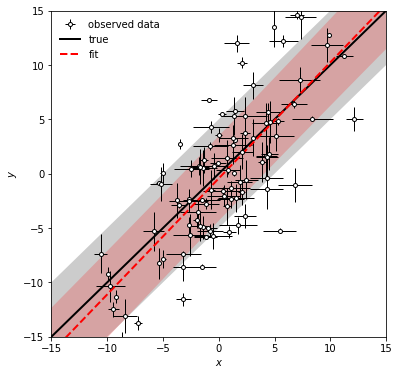

In [8]:
# visualization

fig, ax0 = plt.subplots(1, 1, figsize=(6,6), sharex=True, sharey=True)

lo = ax0.errorbar(x, y, dy, dx, c='k', ls='', lw=1, marker='o', ms=4, mfc='w', label='observed data')
lt, = ax0.plot([-20,20], [a_true+b_true*-20,a_true+b_true*20], 
    c='k', lw=2, label='true')
ax0.fill_between([-20,20], 
    [a_true+b_true*-20-sig_true,a_true+b_true*20-sig_true],
    [a_true+b_true*-20+sig_true,a_true+b_true*20+sig_true], fc='k', ec='none', alpha=0.2)
lf, = ax0.plot([-20,20], [np.mean(a)+np.mean(b)*-20,np.mean(a)+np.mean(b)*20], 
    c='r', lw=2, ls='--', label='fit')
plot_linear_fit_with_error(ax0, -20, 20, 0, 0, 
    np.mean(a), np.std(a), np.mean(b), np.std(b), np.mean(sig), np.std(sig),
    fc='r', ec='none', alpha=0.2)

# plot parameters
ax0.set_xlabel(r'$x$')
ax0.set_ylabel(r'$y$')
ax0.set_xlim(-15, 15)
ax0.set_ylim(-15, 15)

ax0.legend(handles=[lo, lt, lf], frameon=False)
plt.show()